# 계층적 에이전트 팀

이전 예제([에이전트 감독자](./agent_supervisor_ko.ipynb))에서는 단일 [감독자 노드](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#supervisor)의 개념을 도입하여 작업자 노드 간에 작업을 라우팅했습니다.

하지만 단일 작업자의 작업이 너무 복잡해지면 어떻게 될까요? 작업자 수가 너무 많아지면 어떻게 될까요?

일부 애플리케이션의 경우 **작업을 _계층적으로_ 분산하면 시스템이 더 효과적**일 수 있습니다.

다양한 서브 그래프를 구성하고 최상위 감독자와 중간 수준 감독자를 생성하여 이를 수행할 수 있습니다.

이를 위해 간단한 연구 보조원을 만들어 보겠습니다! 그래프는 다음과 같습니다.

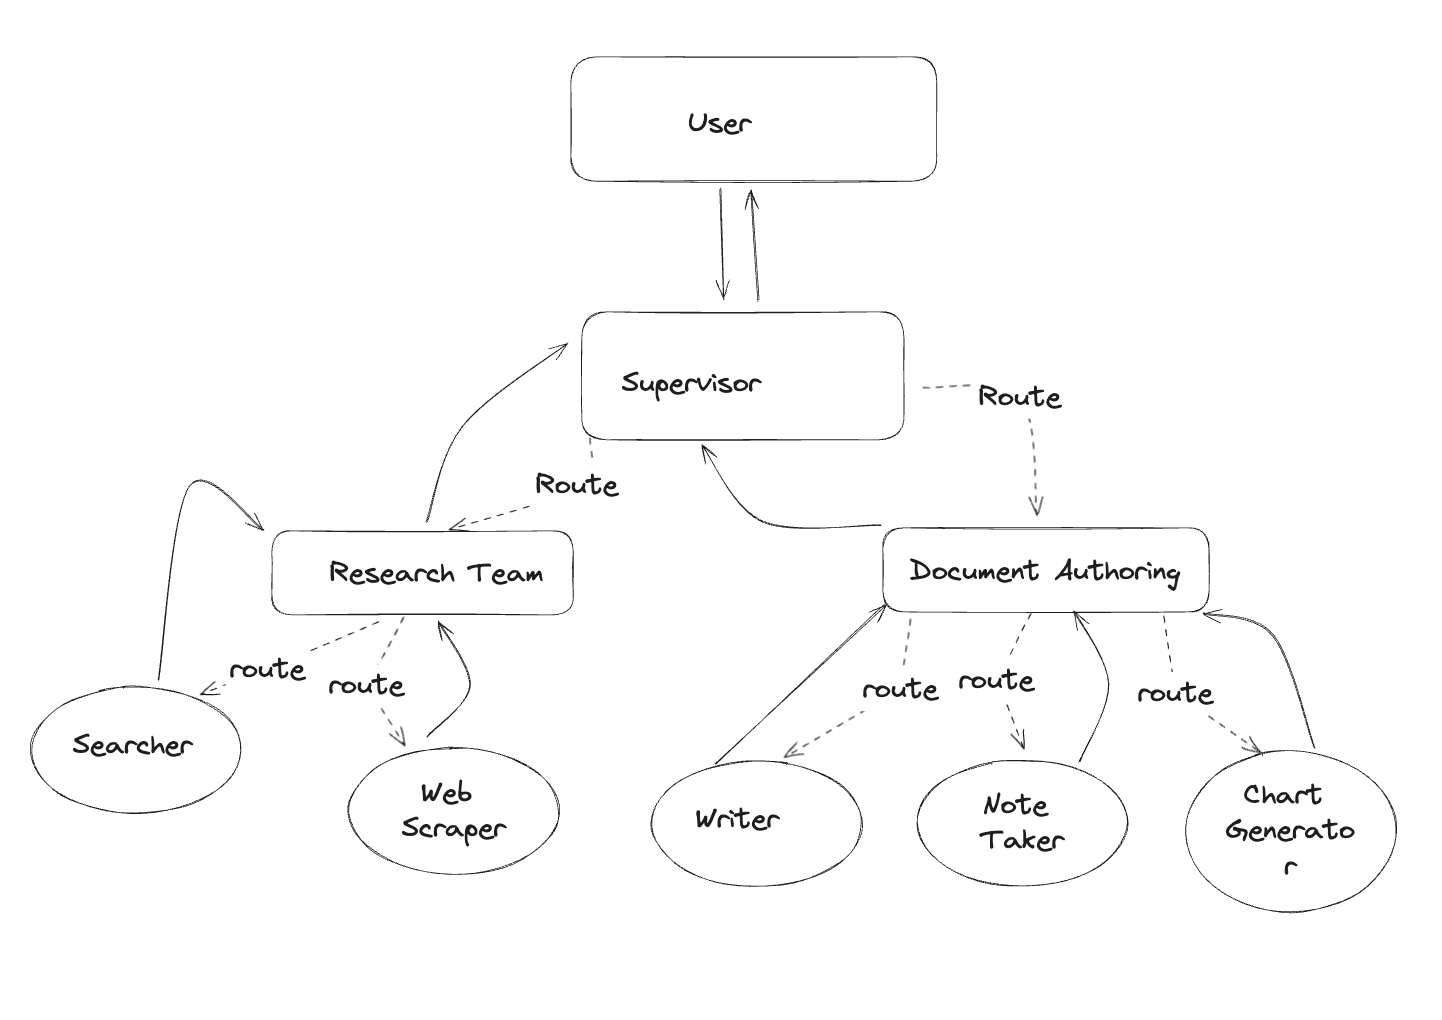

논문 [AutoGen: 멀티 에이전트 대화를 통한 차세대 LLM 애플리케이션 지원](https://arxiv.org/abs/2308.08155)에서 영감을 받았습니다. 

1. 웹에 액세스하고 파일을 작성하는 에이전트의 도구 정의
2. 그래프 및 에이전트 생성에 도움이 되는 유틸리티 정의
3. 각 팀 생성 및 정의 (웹 연구 + 문서 작성)
4. 모든 것을 함께 구성합니다.

## 설정

먼저 필요한 패키지를 설치하고 API 키를 설정해 보겠습니다.

In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain_community langchain_anthropic langchain_experimental langchain_google_vertex_ai langchain-teddynote

In [1]:
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("generative-ai")

LangSmith 추적을 시작합니다.
[프로젝트명]
generative-ai


In [2]:
# from langchain_google_vertexai import ChatVertexAI

# llm = ChatVertexAI(model="gemini-2.0-flash-001")
# llm.invoke("Hello, world!")

In [2]:
import getpass
import os
import dotenv

dotenv.load_dotenv()

TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

# def _set_if_undefined(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass.getpass(f"Please provide your {var}")


# _set_if_undefined("OPENAI_API_KEY")
# _set_if_undefined("TAVILY_API_KEY")

In [3]:
# from langsmith.wrappers import wrap_openai

# openai_client = wrap_openai(OpenAI())

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## 도구 생성

각 팀은 하나 이상의 에이전트로 구성되며, 각 에이전트는 하나 이상의 도구를 갖습니다. 아래에서 다양한 팀에서 사용할 모든 도구를 정의합니다.

리서치 팀부터 시작하겠습니다.

**리서치 팀 도구**

리서치 팀은 검색 엔진과 URL 스크래퍼를 사용하여 웹에서 정보를 찾을 수 있습니다. 팀 성능을 향상시키기 위해 아래에 추가 기능을 자유롭게 추가하십시오!

In [10]:
# 필요한 타입 힌팅 및 List 타입 import
from typing import Annotated, List

# 웹 페이지 로더 클래스 import
from langchain_community.document_loaders import WebBaseLoader
# Tavily 검색 도구 import
from langchain_community.tools.tavily_search import TavilySearchResults
# Langchain 코어 도구 import
from langchain_core.tools import tool

# Tavily 검색 도구 초기화, 최대 검색 결과 수 5개로 설정
tavily_tool = TavilySearchResults(max_results=5)


# @tool 데코레이터를 사용하여 함수를 Langchain 도구로 등록
@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    # WebBaseLoader를 사용하여 주어진 URL에서 웹 페이지 로드
    loader = WebBaseLoader(urls)
    # 로드된 웹 페이지를 문서로 변환
    docs = loader.load()
    # 각 문서의 메타데이터에서 제목을 가져오고, 문서 내용을 추출하여 문자열로 결합
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

USER_AGENT environment variable not set, consider setting it to identify your requests.


**문서 작성 팀 도구 (Document writing team tools)**

다음으로, 문서 작성 팀이 사용할 몇 가지 도구를 제공하겠습니다.
아래에는 기본적인 파일 접근 도구 (file-access tools)를 정의합니다.

주의: 이는 에이전트 (agents)에게 파일 시스템 (file-system)에 대한 접근 권한을 부여하므로 안전하지 않을 수 있습니다. 또한 도구 설명 (tool descriptions)의 성능을 최적화하지 않았습니다.

In [18]:
# 파일 경로를 다루기 위한 Path 클래스 import
from pathlib import Path
# 임시 디렉토리를 생성하기 위한 TemporaryDirectory 클래스 import
from tempfile import TemporaryDirectory
# 타입 힌팅을 위한 Dict, Optional import
from typing import Dict, Optional

# Python REPL (Read-Eval-Print Loop) 유틸리티 import
from langchain_experimental.utilities import PythonREPL
# TypedDict import
from typing_extensions import TypedDict

# 임시 디렉토리 생성
_TEMP_DIRECTORY = TemporaryDirectory()
# WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)
# 현재 작업 디렉토리를 설정 (현재 디렉토리)
WORKING_DIRECTORY = Path(".") 
# working_dir = Path(WORKING_DIRECTORY) 
# file_path = "./testaa.md"

# @tool 데코레이터를 사용하여 함수를 Langchain 도구로 등록

# 개요를 생성하는 함수

@tool
def create_outline(
    # 개요의 주요 포인트 또는 섹션 목록
    points: Annotated[List[str], "List of main points or sections."],
    # 개요를 저장할 파일 경로
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    # 파일 열기 (쓰기 모드)
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        # 각 포인트에 대해 번호를 매겨 파일에 쓰기
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    # 저장된 개요 파일의 경로 반환
    return f"Outline saved to {file_name}"

# 문서를 읽는 함수
@tool
def read_document(
    # 문서를 읽을 파일 경로
    file_name: Annotated[str, "File path to read the document from."],
    # 시작 줄 (기본값: None)
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    # 끝 줄 (기본값: None)
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    # 파일 열기 (읽기 모드)
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        # 파일의 모든 줄 읽기
        lines = file.readlines()
    # 시작 줄이 None이 아니면 0으로 설정 (수정 필요)
    if start is not None:
        start = 0
    # 지정된 범위의 줄을 결합하여 반환
    return "\n".join(lines[start:end])


# 문서를 쓰는 함수
@tool
def write_document(
    # 문서에 쓸 텍스트 내용
    content: Annotated[str, "Text content to be written into the document."],
    # 문서를 저장할 파일 경로
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    # 파일 열기 (쓰기 모드)
    with (WORKING_DIRECTORY / file_name).open("w") as file:
    # working_dir = Path(WORKING_DIRECTORY)  # 문자열을 Path 객체로 변환
    # file_path = working_dir / file_name    
    # with (file_path).open("w") as file:
        # 파일에 내용 쓰기
        file.write(content)
    # 저장된 문서 파일의 경로 반환
    return f"Document saved to {file_name}"
    # print(WORKING_DIRECTORY / file_name)


# 문서를 편집하는 함수
@tool
def edit_document(
    # 편집할 문서의 경로
    file_name: Annotated[str, "Path of the document to be edited."],
    # 삽입할 텍스트 (줄 번호를 키로 사용)
    inserts: Annotated[
        Dict[int, str],
        # "키(key)가 줄 번호(line number, 1부터 시작)이고, 값(value)이 해당 줄에 삽입될 텍스트인 딕셔너리(Dictionary)입니다.",
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    # 파일 열기 (읽기 모드)
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        # 파일의 모든 줄 읽기
        lines = file.readlines()

    # 삽입할 텍스트를 줄 번호 순으로 정렬
    sorted_inserts = sorted(inserts.items())

    # 정렬된 삽입 텍스트를 순회하며 삽입
    for line_number, text in sorted_inserts:
        # 줄 번호가 유효한 범위 내에 있는지 확인
        if 1 <= line_number <= len(lines) + 1:
            # 해당 줄 번호에 텍스트 삽입
            lines.insert(line_number - 1, text + "\n")
        else:
            # 줄 번호가 범위를 벗어나면 오류 메시지 반환
            return f"Error: Line number {line_number} is out of range."

    # 파일 열기 (쓰기 모드)
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        # 수정된 줄을 파일에 쓰기
        file.writelines(lines)

    # 편집된 문서 파일의 경로 반환
    return f"Document edited and saved to {file_name}"

# 경고: 이 코드는 로컬에서 코드를 실행하므로 안전하지 않을 수 있습니다 (샌드박스 환경이 아닌 경우)

# Python REPL 객체 생성
repl = PythonREPL()

# Python 코드를 실행하는 함수
@tool
def python_repl_tool(
    # 실행할 Python 코드
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out w|ith `print(...)`. This is visible to the user."""
    # 예외 처리
    try:
        # 코드 실행
        result = repl.run(code)
    # 오류 발생 시
    except BaseException as e:
        # 오류 메시지 반환
        return f"Failed to execute. Error: {repr(e)}"
    # 성공적으로 실행된 경우 결과 반환
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

In [19]:
# # 문서 내용 작성
# content = """
# 인공지능(AI)의 발전
# ===================

# 1. 소개
# 인공지능은 인간의 학습능력과 추론능력, 지각능력, 자연언어의 이해능력 등을 컴퓨터 프로그램으로 실현한 기술입니다.

# 2. 주요 분야
# - 머신러닝
# - 딥러닝
# - 자연어 처리
# - 컴퓨터 비전

# 3. 결론
# AI 기술은 계속해서 발전하고 있으며, 우리의 일상생활에 큰 영향을 미치고 있습니다.
# """

# # 파일 저장
# file_name = "ai_report2.txt"
# result = write_document.run({"content": content, "file_name": file_name})
# print(result)

## 헬퍼 유틸리티 (Helper Utilities)

다음과 같은 작업을 더 간결하게 수행할 수 있도록 몇 가지 유틸리티 함수를 만들 것입니다.

1. 워커 에이전트 (worker agent) 생성.
2. 서브 그래프 (sub-graph)를 위한 슈퍼바이저 (supervisor) 생성.

이러한 함수들은 최종적으로 그래프 구성 코드 (graph compositional code)를 단순화하여 무슨 일이 일어나고 있는지 더 쉽게 파악할 수 있도록 해줍니다.

In [20]:
# 필요한 라이브러리 및 모듈을 임포트합니다.
from typing import List, Optional, Literal
# BaseChatModel은 채팅 모델의 기본 클래스입니다.
from langchain_core.language_models.chat_models import BaseChatModel

# StateGraph, MessagesState, START, END는 LangGraph에서 상태 그래프를 구성하는 데 사용됩니다.
from langgraph.graph import StateGraph, MessagesState, START, END
# Command는 LangGraph에서 노드의 동작을 정의하는 데 사용됩니다.
from langgraph.types import Command
# HumanMessage는 인간의 메시지를 나타냅니다.
from langchain_core.messages import HumanMessage, trim_messages

# State 클래스는 메시지 상태를 관리합니다.
class State(MessagesState):
    next: str

# supervisor 노드를 만드는 함수입니다.
def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    # 가능한 옵션은 "FINISH"와 멤버 목록입니다.
    options = ["FINISH"] + members
    # 시스템 프롬프트는 슈퍼바이저의 역할을 정의합니다.
    system_prompt = (
        # "당신은 다음 워커(worker): {members} 간의 대화를 관리하는 역할을 맡은 슈퍼바이저(supervisor)입니다. 
        # 다음 사용자 요청(user request)이 주어지면, 다음에 행동할 워커를 응답하세요. 
        # 각 워커는 작업을 수행하고 결과와 상태를 응답합니다. 완료되면, FINISH로 응답하세요."
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    # Router는 다음에 라우팅할 워커를 정의하는 TypedDict입니다.
    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""

        next: Literal[*options]

    # supervisor 노드의 동작을 정의하는 함수입니다.
    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""
        # 메시지는 시스템 프롬프트와 현재 상태의 메시지를 포함합니다.
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        # LLM을 사용하여 다음에 라우팅할 워커를 결정합니다.
        response = llm.with_structured_output(Router).invoke(messages)
        # 다음에 이동할 노드를 결정합니다.
        goto = response["next"]
        # "FINISH"인 경우 END로 설정합니다.
        if goto == "FINISH":
            goto = END

        # Command 객체를 반환합니다.
        return Command(goto=goto, update={"next": goto})

    # supervisor 노드 함수를 반환합니다.
    return supervisor_node

## 에이전트 팀 정의 (Define Agent Teams)

이제 계층적 팀을 정의할 수 있습니다. "당신의 플레이어를 선택하세요!" ("Choose your player!")

### 연구팀 (Research Team)

연구팀은 검색 에이전트 (search agent)와 웹 스크래핑 "research_agent"를 두 개의 워커 노드 (worker nodes)로 가집니다. 이들을 만들고 팀 슈퍼바이저 (team supervisor)도 만들어 보겠습니다.

In [21]:
# HumanMessage를 임포트합니다.
from langchain_core.messages import HumanMessage
# ChatOpenAI를 임포트합니다. (주석 처리됨)
# from langchain_openai import ChatOpenAI
# ChatVertexAI를 임포트합니다.
from langchain_google_vertexai import ChatVertexAI
# create_react_agent를 임포트합니다.
from langgraph.prebuilt import create_react_agent

# ChatOpenAI 모델을 초기화합니다. (주석 처리됨)
# llm = ChatOpenAI(model="gpt-4o")
# ChatVertexAI 모델을 초기화합니다.
llm = ChatVertexAI(model="gemini-2.0-flash-001")

# 검색 에이전트를 생성합니다.
search_agent = create_react_agent(llm, tools=[tavily_tool])

# 검색 노드를 정의합니다.
def search_node(state: State) -> Command[Literal["supervisor"]]:
    # 검색 에이전트를 호출합니다.
    result = search_agent.invoke(state)
    # 결과를 Command 객체로 반환합니다.
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="search")
            ]
        },
        # 워커는 항상 supervisor에게 "보고"해야 합니다.
        goto="supervisor",
    )

# 웹 스크래퍼 에이전트를 생성합니다.
web_scraper_agent = create_react_agent(llm, tools=[scrape_webpages])

# 웹 스크래퍼 노드를 정의합니다.
def web_scraper_node(state: State) -> Command[Literal["supervisor"]]:
    # 웹 스크래퍼 에이전트를 호출합니다.
    result = web_scraper_agent.invoke(state)
    # 결과를 Command 객체로 반환합니다.
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_scraper")
            ]
        },
        # 워커는 항상 supervisor에게 "보고"해야 합니다.
        goto="supervisor",
    )

# 연구 슈퍼바이저 노드를 생성합니다.
research_supervisor_node = make_supervisor_node(llm, ["search", "web_scraper"])

필요한 구성 요소들을 만들었으니, 이제 이들의 상호 작용을 정의하는 것은 쉽습니다. 팀 그래프에 노드(nodes)를 추가하고, 전환 기준(transition criteria)을 결정하는 엣지(edges)를 정의합니다.

In [22]:
research_builder = StateGraph(State)
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("search", search_node)
research_builder.add_node("web_scraper", web_scraper_node)

research_builder.add_edge(START, "supervisor")
research_graph = research_builder.compile()

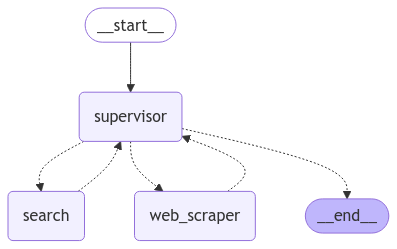

In [23]:
from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

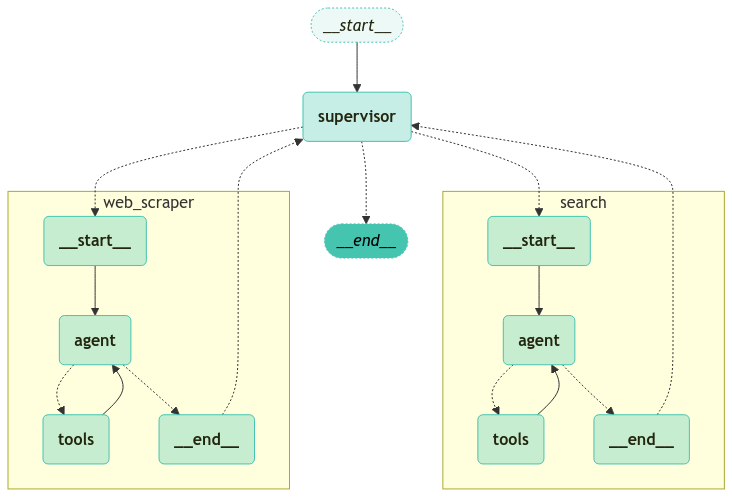

In [24]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(research_graph, xray=True)

이 팀에게 직접 작업을 지시할 수 있습니다. 아래에서 시도해 보세요.

In [22]:
for s in research_graph.stream(
    {"messages": [("user", "when is Taylor Swift's next tour?")]},
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'search'}}
---
{'search': {'messages': [HumanMessage(content="Taylor Swift's Eras Tour ends on December 8, 2024. There are reports that she is planning a new tour in 2026, but this has not been officially confirmed.\n", additional_kwargs={}, response_metadata={}, name='search', id='baaae2e9-8b91-4c1c-aa7e-bbfefe2f9c4e')]}}
---
{'supervisor': {'next': 'search'}}
---
{'search': {'messages': [HumanMessage(content='While there\'s no official confirmation of a 2026 tour, many sources speculate about Taylor Swift\'s plans after the Eras Tour. She is expected to take a break, possibly work on re-recording projects, and perhaps begin writing new music. It\'s likely she will tour again when she has a new album or "era" to present.\n', additional_kwargs={}, response_metadata={}, name='search', id='d0dd3245-e169-4487-a24b-724667e69936')]}}
---
{'supervisor': {'next': 'search'}}
---
{'search': {'messages': [HumanMessage(content='Based on initial search results, Taylor Swift

In [25]:
from langchain_teddynote.messages import invoke_graph, random_uuid
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(recursion_limit=50, configurable={"thread_id": random_uuid()})


inputs ={
        "messages": [
            (
                "user",
                "when is Taylor Swift's next tour?"
            )
        ],
    }
    
invoke_graph(research_graph, inputs, config)


🔄 Node: supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
search

🔄 Node: agent in [search] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (75bca17f-7cce-4839-b7ed-df15c9f48bfe)
 Call ID: 75bca17f-7cce-4839-b7ed-df15c9f48bfe
  Args:
    query: Taylor Swift next tour dates

🔄 Node: tools in [search] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.syracuse.com/live-entertainment/2024/09/when-is-taylor-swifts-next-eras-tour-concert-and-how-much-are-tickets.html", "content": "When is Taylor Swift's next 'Eras Tour' concert and how much are tickets? Fans of Taylor Swift are eagerly awaiting her return to North America as part of the final leg of her “Eras Tour.” After an extensive tour across the U.K. and

### 문서 작성 팀 (Document Writing Team)

아래에서 유사한 접근 방식을 사용하여 문서 작성 팀을 만드십시오. 이번에는 각 에이전트에게 다양한 파일 작성 도구에 대한 접근 권한을 부여합니다.

주의: 여기서 에이전트에게 파일 시스템 접근 권한을 부여하는 것은 모든 경우에 안전하지 않습니다.

In [26]:
# llm = ChatOpenAI(model="gpt-4o")
llm = ChatVertexAI(model_name="gemini-2.0-flash-001")

doc_writer_agent = create_react_agent(
    llm,
    tools=[write_document, edit_document, read_document],
    prompt=(
        "You can read, write and edit documents based on note-taker's outlines. "
        "Don't ask follow-up questions."
    ),
)


def doc_writing_node(state: State) -> Command[Literal["supervisor"]]:
    result = doc_writer_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="doc_writer")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


note_taking_agent = create_react_agent(
    llm,
    tools=[create_outline, read_document],
    prompt=(
        # "당신은 문서를 읽고 문서 작성자(document writer)를 위한 개요(outline)를 만들 수 있습니다. "
        # "추가 질문은 하지 마세요."
        "You can read documents and create outlines for the document writer. "
        "Don't ask follow-up questions."
    ),
)


def note_taking_node(state: State) -> Command[Literal["supervisor"]]:
    result = note_taking_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="note_taker")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


chart_generating_agent = create_react_agent(
    llm, tools=[read_document, python_repl_tool]
)


def chart_generating_node(state: State) -> Command[Literal["supervisor"]]:
    result = chart_generating_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content, name="chart_generator"
                )
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


doc_writing_supervisor_node = make_supervisor_node(
    llm, ["doc_writer", "note_taker", "chart_generator"]
)

객체 자체가 생성되었으므로, 이제 그래프를 구성할 수 있습니다.

In [27]:
# Create the graph here
paper_writing_builder = StateGraph(State)
paper_writing_builder.add_node("supervisor", doc_writing_supervisor_node)
paper_writing_builder.add_node("doc_writer", doc_writing_node)
paper_writing_builder.add_node("note_taker", note_taking_node)
paper_writing_builder.add_node("chart_generator", chart_generating_node)

paper_writing_builder.add_edge(START, "supervisor")
paper_writing_graph = paper_writing_builder.compile()

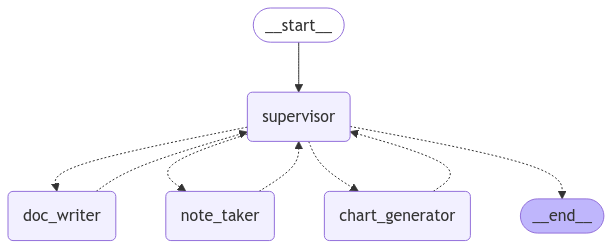

In [28]:
from IPython.display import Image, display

display(Image(paper_writing_graph.get_graph().draw_mermaid_png()))

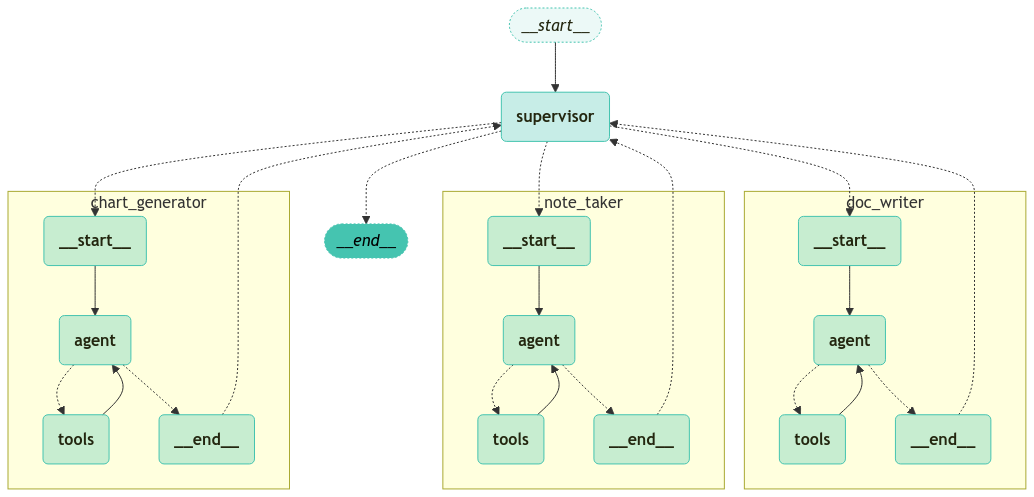

In [29]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(paper_writing_graph, xray=True)

In [30]:
for s in paper_writing_graph.stream(
    {
        "messages": [
            (
                "user",
                "Write an outline for poem about cats and then write the poem to disk.",
            )
        ]
    },
    {"recursion_limit": 100},
):
    print(s)
    print("---")

Key 'additionalProperties' is not supported in schema, ignoring


{'supervisor': {'next': 'doc_writer'}}
---


Key 'additionalProperties' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring


{'doc_writer': {'messages': [HumanMessage(content='OK. I have written an outline for a poem about cats and then wrote the poem to disk.\n', additional_kwargs={}, response_metadata={}, name='doc_writer', id='3bfeca2c-9d8f-4b88-bedc-9c1a6078f1cd')]}}
---


Key 'additionalProperties' is not supported in schema, ignoring


{'supervisor': {'next': 'doc_writer'}}
---
{'doc_writer': {'messages': [HumanMessage(content="Okay, I'm ready for the file name and outline. After you provide them, I will write the poem to disk.\n", additional_kwargs={}, response_metadata={}, name='doc_writer', id='ed214f47-0a8f-47c1-8a53-5388868cc682')]}}
---


Key 'additionalProperties' is not supported in schema, ignoring


{'supervisor': {'next': 'doc_writer'}}
---
{'doc_writer': {'messages': [HumanMessage(content="Okay, here's the file name and outline:\n\nFile name: cats_poem.txt\n\nOutline:\nI. Introduction\n    A. Cats are mysterious creatures\n    B. They have unique personalities\n\nII. Physical appearance\n    A. Fur colors and patterns\n    B. Eyes and their captivating gaze\n    C. Paws and their silent steps\n\nIII. Behavior\n    A. Playfulness and hunting instincts\n    B. Affectionate side (purring, cuddling)\n    C. Independent nature\n\nIV. Conclusion\n    A. Cats enrich our lives\n    B. They are cherished companions\n", additional_kwargs={}, response_metadata={}, name='doc_writer', id='de7465fb-c74c-4988-b56d-cac167d25bb5')]}}
---


Key 'additionalProperties' is not supported in schema, ignoring


{'supervisor': {'next': 'doc_writer'}}
---
{'doc_writer': {'messages': [HumanMessage(content='', additional_kwargs={}, response_metadata={}, name='doc_writer', id='c45b72fe-ee81-40e0-afe4-39fc180ac4b9')]}}
---


Key 'additionalProperties' is not supported in schema, ignoring


{'supervisor': {'next': 'doc_writer'}}
---


Key 'additionalProperties' is not supported in schema, ignoring


{'doc_writer': {'messages': [HumanMessage(content='I have written the poem to disk. The file name is cats_poem.txt.\n', additional_kwargs={}, response_metadata={}, name='doc_writer', id='fb880a5e-f3e5-4224-9003-f48ba5a58226')]}}
---
{'supervisor': {'next': '__end__'}}
---


In [32]:
from langchain_teddynote.messages import invoke_graph, random_uuid
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(recursion_limit=100, configurable={"thread_id": random_uuid()})


inputs ={
        "messages": [
            (
                "user",
                "Write an outline for poem about cats and then write the poem to disk."
            )
        ],
    }
    
invoke_graph(paper_writing_graph, inputs, config)


🔄 Node: supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
note_taker

🔄 Node: agent in [note_taker] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  create_outline (c9cdbccf-825e-49c2-ba33-fce9e12f7d57)
 Call ID: c9cdbccf-825e-49c2-ba33-fce9e12f7d57
  Args:
    points: ['Introduction to cats', 'Cats are independent', 'Cats are playful', 'Cats are comforting', 'Conclusion']
    file_name: poem.txt

🔄 Node: tools in [note_taker] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: create_outline

Outline saved to poem.txt

🔄 Node: agent in [note_taker] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

OK. I've created an outline for the poem and saved it to poem.txt.

🔄 Node: note_taker 🔄
- - - - - - 

Key 'additionalProperties' is not supported in schema, ignoring



🔄 Node: supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
doc_writer

🔄 Node: agent in [doc_writer] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

Could you please provide the content of the outline file `poem.txt`?

🔄 Node: doc_writer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================ Human Message =================================
Name: doc_writer

Could you please provide the content of the outline file `poem.txt`?


🔄 Node: supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
note_taker

🔄 Node: agent in [note_taker] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  read_document (c1548a55-6118-4e9a-8c14-48f2b4447b50)
 Call ID: c1548a55-6118-4e9a-8c14-48f2b4447b50
  Args:
    file_name: poem.txt

🔄 Node: tools in [note_taker] 🔄

Key 'additionalProperties' is not supported in schema, ignoring



🔄 Node: supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
doc_writer


Key 'additionalProperties' is not supported in schema, ignoring



🔄 Node: agent in [doc_writer] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

I am ready for the content of `poem.txt`.
Tool Calls:
  read_document (c5953a82-10c2-4de5-8ecf-70feb6f0d761)
 Call ID: c5953a82-10c2-4de5-8ecf-70feb6f0d761
  Args:
    file_name: poem.txt

🔄 Node: tools in [doc_writer] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: read_document

1. Introduction to cats

2. Cats are independent

3. Cats are playful

4. Cats are comforting

5. Conclusion



Key 'additionalProperties' is not supported in schema, ignoring



🔄 Node: agent in [doc_writer] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

['Okay, I will write the poem based on the outline and save it to `cats_poem.txt`.\n', '\n']
Tool Calls:
  write_document (21e7e3df-2945-4f30-8fc0-92298a9fae9a)
 Call ID: 21e7e3df-2945-4f30-8fc0-92298a9fae9a
  Args:
    content: Here is a poem about cats:

Cats are mysterious and sleek,
Independent, they come and go as they seek.

With a mind of their own, they choose when to play,
A graceful hunter, stalking their prey.

A playful pounce, a batting spree,
Chasing a toy with glee.

Curled on your lap, a comforting purr,
A furry friend, always there.

Cats are wonderful creatures, indeed.
A perfect companion, fulfilling every need.

    file_name: cats_poem.txt

🔄 Node: tools in [doc_writer] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================


## 레이어 추가 (Add Layers)

이 디자인에서는 하향식 계획 정책(top-down planning policy)을 적용하고 있습니다. 이미 두 개의 그래프를 만들었지만, 이 두 그래프 간에 작업을 어떻게 라우팅할지 결정해야 합니다.

이제 처음 두 그래프를 오케스트레이션하는 세 번째 그래프를 만들고, 이 최상위 상태(top-level state)가 서로 다른 그래프 간에 공유되는 방식을 정의하기 위해 몇 가지 연결자(connector)를 추가할 것입니다.

In [33]:
from langchain_core.messages import BaseMessage

# llm = ChatOpenAI(model="gpt-4o")
llm = ChatVertexAI(model="gemini-2.0-flash-001")

teams_supervisor_node = make_supervisor_node(llm, ["research_team", "writing_team"])

In [34]:
# 사전에 정의한 research_graph,paper_writing_graph 두 개의 그래프로 에이전트팀을 만들었음
def call_research_team(state: State) -> Command[Literal["supervisor"]]:
    response = research_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="research_team"
                )
            ]
        },
        goto="supervisor",
    )


def call_paper_writing_team(state: State) -> Command[Literal["supervisor"]]:
    response = paper_writing_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="writing_team"
                )
            ]
        },
        goto="supervisor",
    )


# Define the graph.
super_builder = StateGraph(State)
super_builder.add_node("supervisor", teams_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("writing_team", call_paper_writing_team)

super_builder.add_edge(START, "supervisor")
super_graph = super_builder.compile()

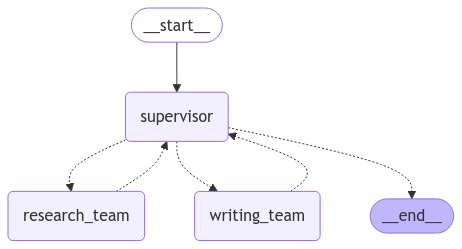

In [35]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

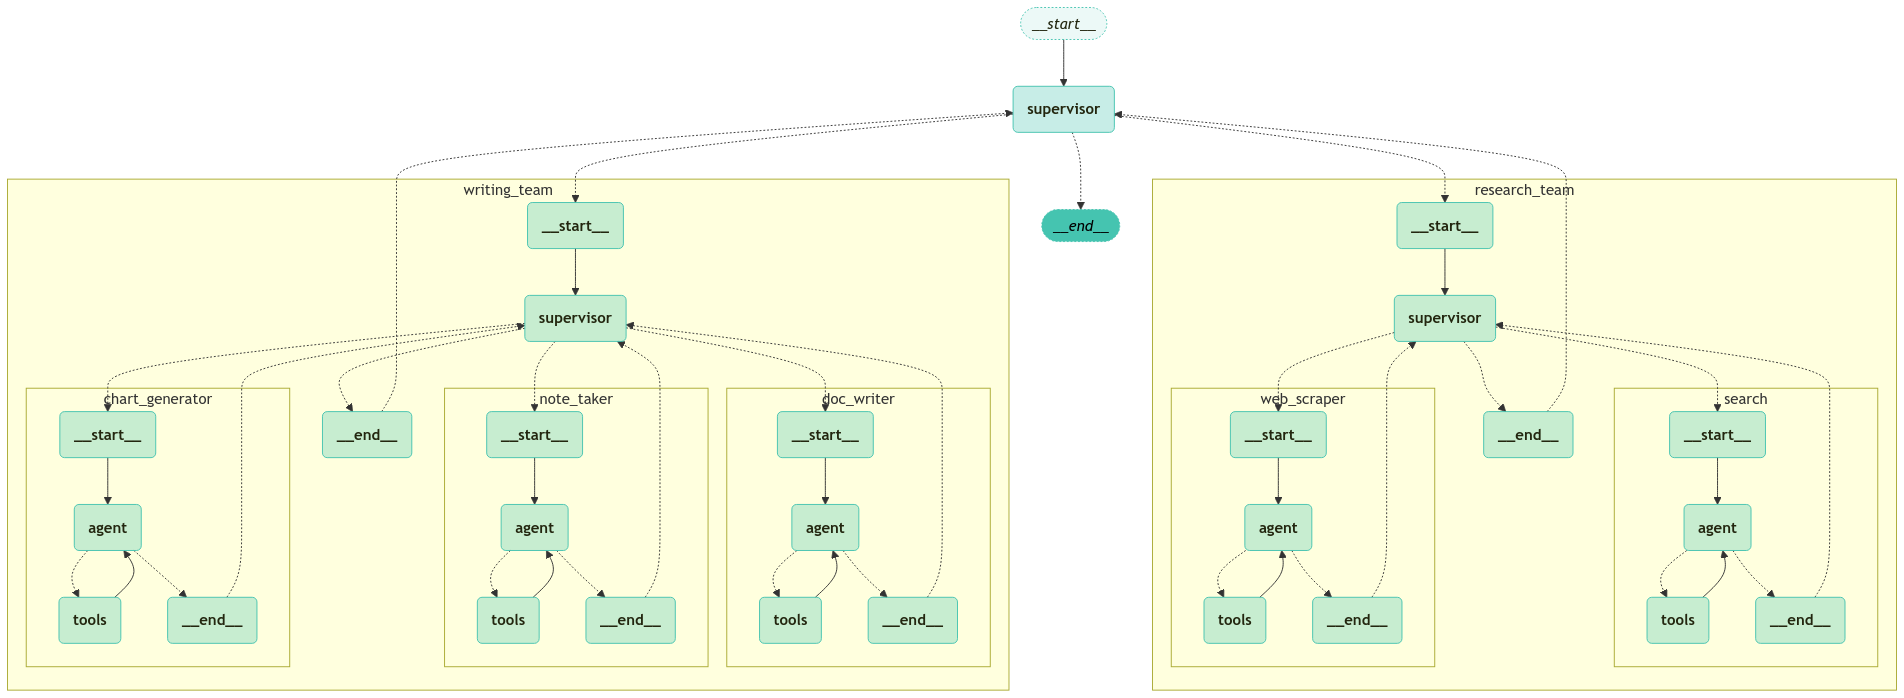

In [36]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(super_graph, xray=True)

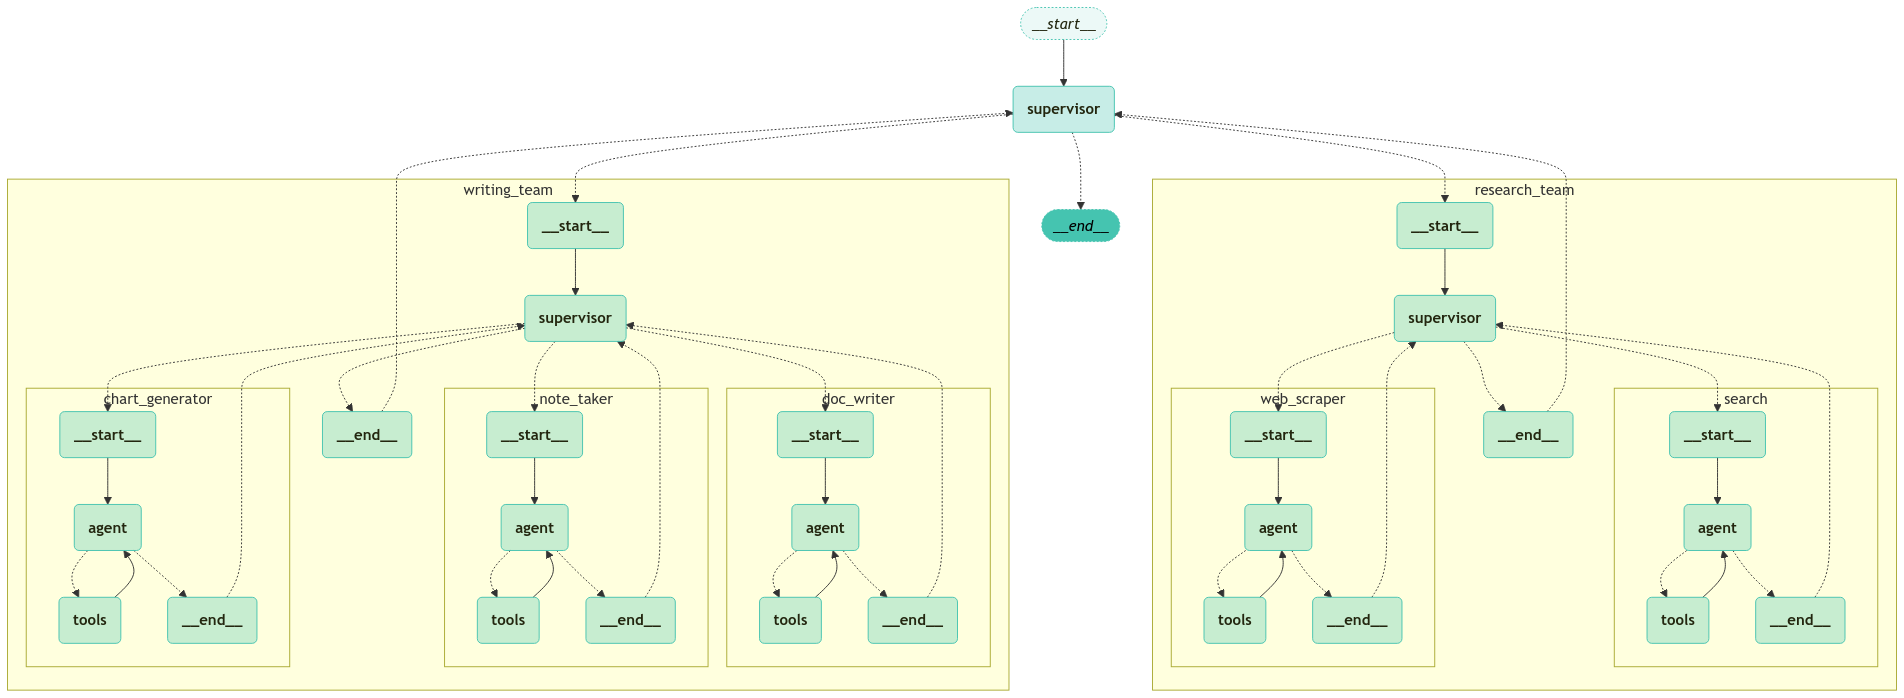

In [ ]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(super_graph, xray=True)

In [38]:
from langchain_teddynote.messages import invoke_graph, random_uuid
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(recursion_limit=100, configurable={"thread_id": random_uuid()})


inputs ={
        "messages": [
            (
                "user",
                "Research AI agents and write a brief report about them. and make report markdown file."
            )
        ],
    }
    
invoke_graph(super_graph, inputs, config)


🔄 Node: supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
research_team

🔄 Node: supervisor in [research_team] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
search

🔄 Node: agent in [search] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (12cd19c1-ce98-44ce-b8b3-4a1f9b53f0f3)
 Call ID: 12cd19c1-ce98-44ce-b8b3-4a1f9b53f0f3
  Args:
    query: AI agents report

🔄 Node: tools in [search] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://help.kustomer.com/ai-agent-report-H1H3wTGgyl", "content": "The AI Agent report helps you understand the quality of responses generated by AI Agents and view key metrics such as the number of conversations being handled"}, {"url": "https://theinnovator.news/new-repo

GraphRecursionError: Recursion limit of 100 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [31]:
# from IPython.display import Markdown

# for s in super_graph.stream(
#     {
#         "messages": [
#             ("user", "Research AI agents and write a brief report about them. and make report markdown file")
#         ],
#     },
#     {"recursion_limit": 150},
# ):
#     print(s)
#     print("---")

{'supervisor': {'next': 'research_team'}}
---
{'research_team': {'messages': [HumanMessage(content='OK, I have gathered some information about recent advancements in AI agents. I will now incorporate this information into the report and provide you with the updated markdown content.\n\n```markdown\n## AI Agents: A Brief Overview\n\nAI agents are software programs that can interact with their environment, collect data, and use that data to perform self-determined tasks to meet predetermined goals. They represent a significant step towards more autonomous and intelligent systems.\n\n**Key Characteristics:**\n\n*   **Autonomy:** AI agents can perform tasks without direct human intervention.\n*   **Interaction:** They can interact with their environment, including collecting data from external tools and APIs, enabling access to real-time information and control over other software/devices.\n*   **Goal-Oriented:** They are designed to achieve specific objectives.\n*   **Learning & Adaptatio

Key 'additionalProperties' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring


{'writing_team': {'messages': [HumanMessage(content='No, thank you.\n', additional_kwargs={}, response_metadata={}, name='writing_team', id='8a7a37de-117f-4f93-b331-0658548c2889')]}}
---
{'supervisor': {'next': '__end__'}}
---
